In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.processing import phase_preprocess
from deepcell.applications import MultiplexSegmentation

In [2]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img, :, :], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [3]:
weights = '/data/models/20200619_production_updates/20200908_multiplex_deep_watershed.h5'

In [4]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256,256, 2),
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

W0915 21:42:03.805484 140305114519360 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
model.load_weights(weights)

In [6]:
# create folder for this set of experiments
experiment_folder = "20200619_production_updates"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

    from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200908_multiplex_"

train_dict = np.load(NPZ_DIR + npz_name + "train_512x512.npz")
val_dict = np.load(NPZ_DIR + npz_name + "val_256x256.npz")
test_dict = np.load(NPZ_DIR + npz_name + "test_256x256.npz")
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

In [7]:
k=128
# X_train = phase_preprocess(X_train, k)
# X_val = phase_preprocess(X_val, k)

X_test = phase_preprocess(X_test, k)

In [8]:
# X_train_blank = np.zeros_like(X_train)
# X_val_blank = np.zeros_like(X_val)
X_test_blank = np.zeros_like(X_test)

In [9]:
# X_train_blank[..., 0] = X_train[..., 0]
# X_val_blank[..., 0] = X_val[..., 0]
X_test_blank[..., 0] = X_test[..., 0]

In [10]:
from deepcell.applications import MultiplexSegmentation
from deepcell_toolbox.utils import tile_image, untile_image
from deepcell_toolbox.processing import phase_preprocess
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
app = MultiplexSegmentation(use_pretrained_weights=False)

In [11]:
tiled_data, tile_info = tile_image(X_test_blank, model_input_shape=(256, 256), stride_ratio=1)

In [12]:
model_output = model.predict(tiled_data)
inner_distance, outer_distance, fgbg, pixelwise = app._untile_output(model_output, tile_info)

In [13]:
predictions1 = deep_watershed_mibi({'inner-distance':inner_distance,
                                  'pixelwise-interior': pixelwise[:, ..., 1:2]},
                                  maxima_threshold=0.05, maxima_model_smooth=0,
                                  interior_threshold=0.4,
                                  interior_model_smooth=2,
                                  radius=5,
                                  small_objects_threshold=10,
                                  fill_holes_threshold=10)

In [14]:
RGB_data = make_color_overlay(X_test)

In [15]:
predicted_overlay = make_outline_overlay(RGB_data, predictions1[:, ..., 0])

(2029, 256, 256, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


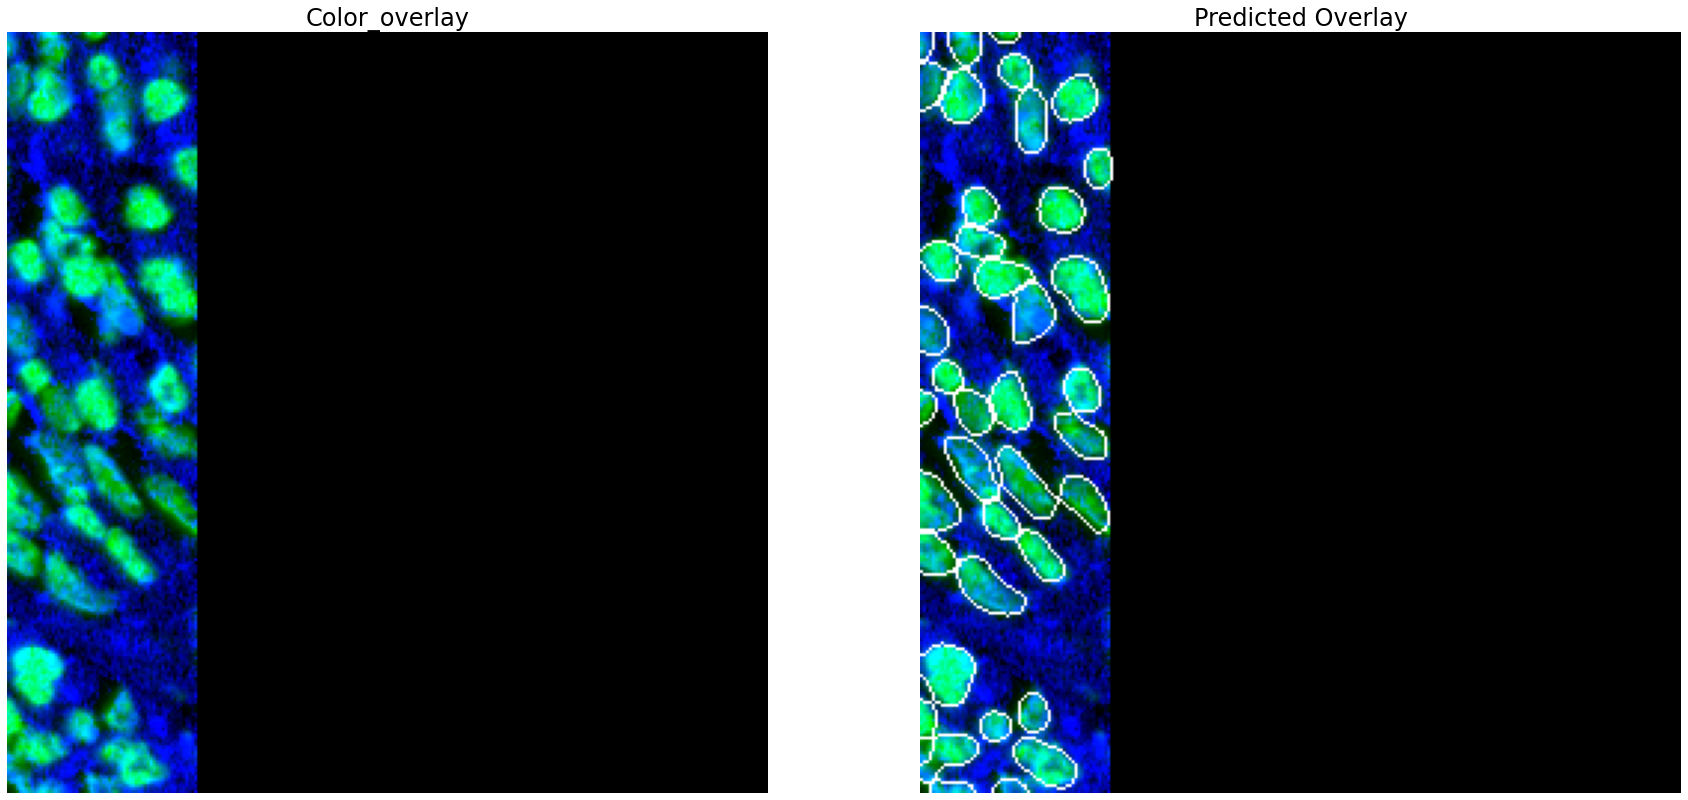

In [26]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 750
fig, axes = plt.subplots(1,2,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(RGB_data[index,...])
axes[1].imshow(predicted_overlay[index, ...], cmap=cmap)

axes[0].set_title('Color_overlay', fontsize=24)
axes[1].set_title('Predicted Overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

In [30]:
predictions = np.concatenate((predictions1, predictions2), axis=0)

In [30]:
predictions.shape

(2029, 256, 256, 1)

In [29]:
predictions = predictions1

In [32]:
# set non-nuclear pixels to zero
nuclear_predictions = np.copy(y_test)
for i in range(nuclear_predictions.shape[0]):
    zero_mask = predictions[i, :, :, 0] == 0
    nuclear_predictions[i, zero_mask, 0] = 0

In [33]:
# relabel objects
from skimage.measure import label
for i in range(nuclear_predictions.shape[0]):
    nuclear_predictions[i, ..., 0] = label(nuclear_predictions[i, ..., 0])

In [34]:
# remove stray pixels
from skimage.morphology import remove_small_objects
for i in range(nuclear_predictions.shape[0]):
    nuclear_predictions[i, ..., 0] = remove_small_objects(nuclear_predictions[i, ..., 0],
                                                         min_size=10)

(2029, 256, 256, 1)

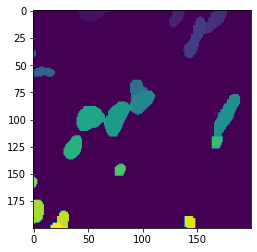

In [38]:
import matplotlib.pyplot as plt
plt.imshow(nuclear_predictions[600, :200, :200, 0])
predictions.shape

(1753, 512, 512, 2)

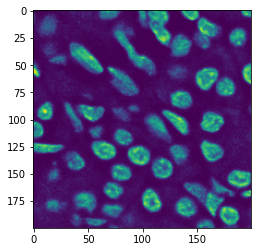

In [37]:
import matplotlib.pyplot as plt
plt.imshow(X_train[110, :200, :200, 0].astype('float32'))
X_train.shape

In [39]:
np.savez_compressed(os.path.join('/data/npz_data/', npz_name + '_nuclear_test_256x256.npz'), 
         X=X_test, 
         y=np.concatenate((y_test, nuclear_predictions), axis=-1))